In [1]:
import numpy as np
from keras.models import Sequential, Model
from keras.layers import LSTM  ,RepeatVector ,TimeDistributed , Dense ,  GRU
from keras.utils import plot_model
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [0]:
#Prepare
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        #print("end_ix="+str(end_ix))
        if end_ix > len(sequence)-1:
            break
        seq_x = [tmp for tmp in sequence[i:end_ix]]
        X.append(seq_x)
    return np.array(X)

seq_step  = 5

In [3]:
!pip install PyDrive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':"141t-yKekBgffrDcn4UF6Z0owgiyjthql"})
downloaded.GetContentFile('xxx_data.csv') 

In [8]:
df = pd.read_csv('xxx_data.csv',names=['eps'])
len(df.eps)

453

In [0]:
#Prepare
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        #print("end_ix="+str(end_ix))
        if end_ix > len(sequence)-1:
            break
        seq_x = [tmp for tmp in sequence[i:end_ix]]
        X.append(seq_x)
    return np.array(X)

seq_step  = 5

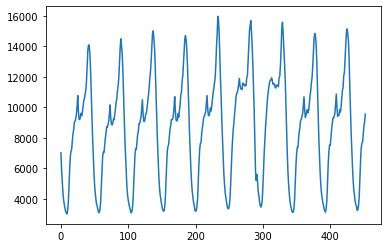

In [10]:
plt.plot(df)

In [11]:
train_set = split_sequence(df.eps.values,seq_step)
display(train_set)
train_set.shape

array([[7009.73, 5900.36, 5076.96, 4375.26, 3925.37],
       [5900.36, 5076.96, 4375.26, 3925.37, 3612.11],
       [5076.96, 4375.26, 3925.37, 3612.11, 3402.24],
       ...,
       [6498.29, 7355.33, 7645.04, 7706.74, 8232.95],
       [7355.33, 7645.04, 7706.74, 8232.95, 8775.92],
       [7645.04, 7706.74, 8232.95, 8775.92, 9039.17]])

(448, 5)

In [12]:
sequence = train_set.reshape(train_set.shape[0],seq_step,-1)
sequence.shape

(448, 5, 1)

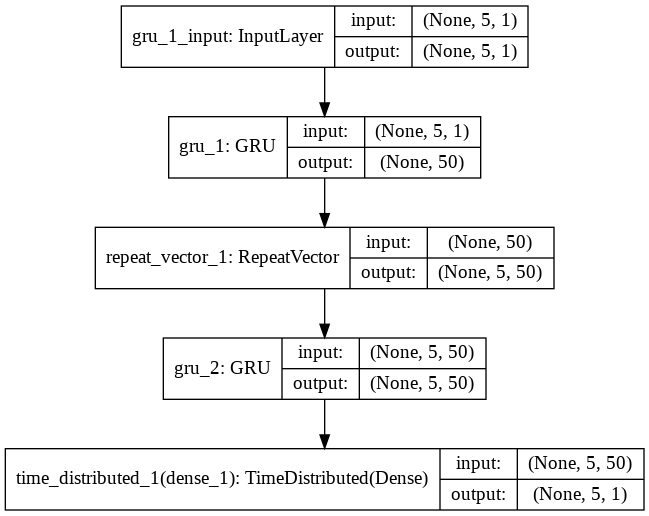

In [13]:
# define model
history=[]
model = Sequential()
model.add(GRU(50, activation='relu', input_shape=(seq_step,1)))
model.add(RepeatVector(seq_step))
model.add(GRU(50, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')
plot_model(model, show_shapes=True, to_file='reconstruct_lstm_autoencoder.png')

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 50)                7800      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 5, 50)             0         
_________________________________________________________________
gru_2 (GRU)                  (None, 5, 50)             15150     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 1)              51        
Total params: 23,001
Trainable params: 23,001
Non-trainable params: 0
_________________________________________________________________


In [0]:
history_tmp=model.fit(sequence, sequence, epochs=5000, verbose=0)
history.extend(history_tmp.history['loss'])

#Train ที่ 5000 epochs ได้ค่า MSE อยู่ที่ ~ 10

10.91979534285409


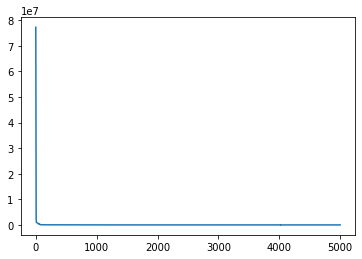

In [16]:
plt.plot(history)
print(history[-1])

In [0]:
model.save("lstm_autoencoder.f5")
model.save_weights("lstm_autoencoder_weight.f5")

In [0]:
model.load_weights('lstm_autoencoder_weight.f5')

In [31]:
test = sequence[119].copy()
test = test.reshape(1,5,1)
test.shape

(1, 5, 1)

# เมื่อนำ Data Test และ Pred มาเทียบกันพบว่าทาบกันสนิทและค่า MSE อยู่ที่ ~ 10 - 11

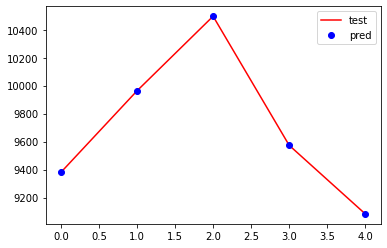

In [33]:
pred = model.predict([test])
pred2 = pred.reshape(5,1)

plt.plot(test.reshape(5,1),'r-')

plt.plot(test.reshape(5,1),'bo')
plt.legend(['test','pred'])

In [21]:
diff = test - pred
print(abs(diff))
print(mean_squared_error(test.reshape(5,1), pred.reshape(5,1)))

[[[0.75015625]
  [1.06351562]
  [4.53109375]
  [4.7315625 ]
  [3.66285156]]]
11.605755143125016


#แก้จุดที่ 2 ให้สูงผิดปรกติ (Anomaly)

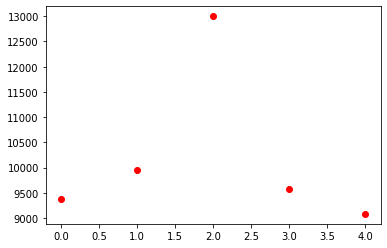

In [22]:
test[0][2][0] = 13000
plt.plot(test.reshape(5,1),'ro')

#ผลที่ได้คือ Predict ออกมาไม่เหมือนกันกับ Data ที่นำเข้าเนื่องจากเราสร้าง anomaly ขึ้นมาเอง Model ไม่เคยเห็นมาก่อน และ MSE มีค่า > 100,000 

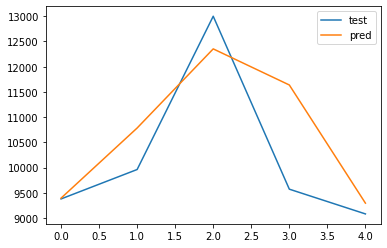

In [23]:
pred = model.predict([test])
pred = pred.reshape(5,1)
plt.plot(test.reshape(5,1))
plt.plot(pred)
plt.legend(['test','pred'])

In [24]:
diff = test - pred
print(abs(diff))
print(mean_squared_error(test.reshape(5,1), pred.reshape(5,1)))

[[[  15.14859375]
  [ 822.42484375]
  [ 646.84960938]
  [2064.71277344]
  [ 213.76097656]]]
1080751.8225110667


# TEST

#เราสร้างจุดที่เป็น Anomaly ขึ้นมา 5 จุดให้เกิดความผิดปรกติขึ้นและนำ Data เข้าไปใน Model

In [0]:
downloaded = drive.CreateFile({'id':"1Ve2rQ4JUOUB3ZAb3vRb1vea9Wx79Q6RP"})
downloaded.GetContentFile('xxx_data4.csv') 
df = pd.read_csv('xxx_data4.csv',names=['eps'])
data1 = df['eps'].values[:]
data1 = np.asarray(data1)
#data1[180] =  20000
data1[90:100] = 10000
data1[10:12] = 12000
data1[50:52] = 7000
data1[150:152] = 7000

In [26]:
test_set = split_sequence(data1,seq_step)
display(test_set[-1])
test_set.shape

array([ 8381.85,  8480.37,  9107.73,  9716.72, 10057.2 ])

(448, 5)

In [0]:
mseval = []
for i in test_set:
    test = i.reshape(1,5,1)
    pred = model.predict([test])
    mse = mean_squared_error(test.reshape(5,1),pred.reshape(5,1))
    mseval.append(mse)

#ตั้ง Threshold ให้กับค่า MSE ไว้ที่ 500

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


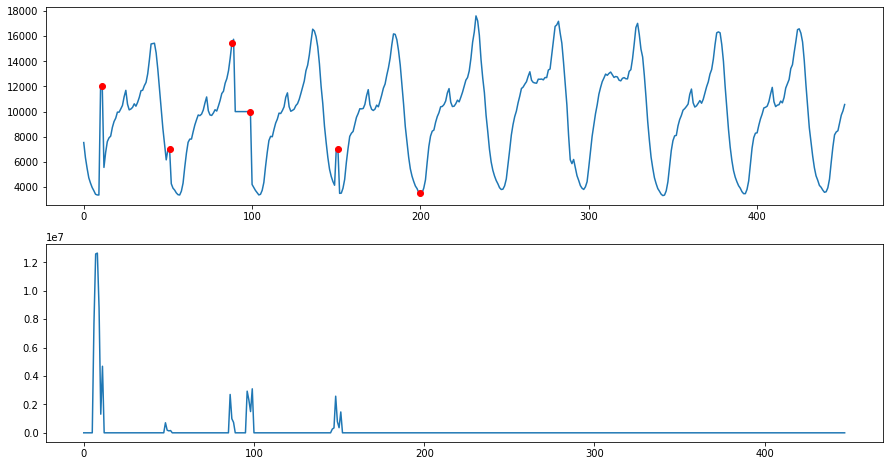

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

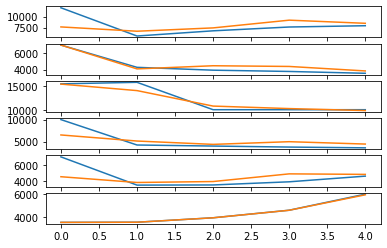

In [28]:
plt.figure(figsize=(15, 8))
anomaly = False
anomaly_pos2 = []
anomaly_pos = 0
threshold = 500
plt.subplot(211).plot(df.eps.values)
for i in range(len(mseval)):
    if mseval[i]  > threshold:
        anomaly = True
        if anomaly_pos < mseval[i]:
            anomaly_pos = i
    elif mseval[i]  < threshold and anomaly == True:
        #Reset Anomaly
        plt.subplot(211).plot(anomaly_pos,df.eps.values[anomaly_pos],'ro')
        anomaly = False
        anomaly_pos2.append(anomaly_pos)
        anomaly_pos = 0
        #display(test_set[anomaly_pos])
plt.subplot(212).plot(mseval)
plt.show()
c = len(anomaly_pos2)
#print(c)
#print(anomaly_pos2)
for i in range(c):
    pos = anomaly_pos2[i]
    #print(i,pos)
    plt.subplot(c,1,i+1).plot(test_set[pos])
    pred = model.predict(test_set[pos].reshape(1,5,1))
    plt.subplot(c,1,i+1).plot(pred.reshape(5,1))
    diff = test_set[pos] - pred
    #print(test_set[pos],pred.reshape(1,5),diff,mseval[pos])